In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# project1
Симуляция за декабрь 2018.
Seed = 27

In [6]:
!python ../anomaly_detection/simulate.py \
    -s 27 \
    -u ../anomaly_detection/user_data/user_base.txt \
    -i ../anomaly_detection/user_data/user_ips.json \
    -l december_2018_log.csv \
    -hl december_2018_attacks.csv \
    31 "2018-12-01"

[INFO] [ simulate.py ] Simulating 31.0 days...
[INFO] [ simulate.py ] Saving logs
[INFO] [ simulate.py ] All done!


# project2
Уникальные имена пользователей, попытки входа, удачные попытки, неудачные попытки, отношение удач к неудачам.

In [7]:
december_inf = pd.read_csv('december_2018_log.csv', parse_dates=True, index_col='datetime')
december_assigned = december_inf.assign(
    failures = lambda x: np.invert(x.success)).groupby('source_ip').agg(
    {'username': 'nunique', 'success': 'sum', 'failures': 'sum'}).assign(
                                                                        attempts=lambda x: x.success + x.failures,
                                                                        success_rate=lambda x: x.success / x.attempts,
                                                                        failure_rate=lambda x: 1 - x.success_rate
                                                                        ).dropna().reset_index()
december_assigned

,source_ip,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,1,14,0,14,1.000000,0.000000
1,1.54.45.23,49,17,68,85,0.200000,0.800000
2,100.43.18.36,1,7,0,7,1.000000,0.000000
3,101.113.31.197,1,10,1,11,0.909091,0.090909
4,101.154.143.93,1,30,5,35,0.857143,0.142857
...,...,...,...,...,...,...,...
330,95.227.178.199,1,6,2,8,0.750000,0.250000
331,96.19.200.227,1,5,0,5,1.000000,0.000000
332,96.42.66.7,1,4,1,5,0.800000,0.200000
333,97.233.182.38,1,8,0,8,1.000000,0.000000


In [8]:
pd.unique(december_assigned.username)

array([  1,  49, 123, 137, 143, 110, 146,  44, 108, 131,  70, 138, 117,
        22, 121, 103,  66,  14,  45, 124,  59,  63, 134, 126,  23,  67,
        12,   2, 139, 132, 135,  60,  64,  79,  75,  58, 129,  47,  54,
       111,  27, 136,  15, 144,  93, 118,  98, 125,  41,  76, 140, 107,
        55, 133, 102,  97,  65, 142], dtype=int64)

In [9]:
pd.unique(december_assigned.success)

array([14, 17,  7, 10, 30,  2,  9, 28, 47,  1,  4, 39, 12, 18,  5,  6, 44,
       13, 34, 45, 20, 38, 32, 42, 31, 15,  8, 24,  3, 40, 19, 36, 35, 21,
       11, 16, 41, 43, 46, 26, 33, 29, 48, 27, 22, 37], dtype=int64)

In [10]:
pd.unique(december_assigned.failures)

array([  0,  68,   1,   5, 188, 202,   2, 216, 167,   3, 208,  61, 151,
       206, 101, 218, 181,  30, 172, 109,  27,  70, 191,  94,  82, 204,
       203,  31,  88,  20,   4, 190, 212,  89,  98, 114, 207,   7, 108,
        79, 183,  60,  74,   9, 154, 158, 211,  46, 201,  25,  24, 128,
         8, 180, 189, 205, 132,  40, 209, 199,  66, 123, 153,  39, 171,
        77, 141, 220, 197, 214,  87], dtype=int64)

In [11]:
december_assigned.success/december_assigned.failures

0        inf
1       0.25
2        inf
3      10.00
4       6.00
       ...  
330     3.00
331      inf
332     4.00
333      inf
334      inf
Length: 335, dtype: float64

# project3
Графики, показывающие отношение неудачных попыток входа к общим попыткам и неудачных попыток к отдельным именам пользователей соответственно.
Построение границ решений, основывающихся на полученных результатах.

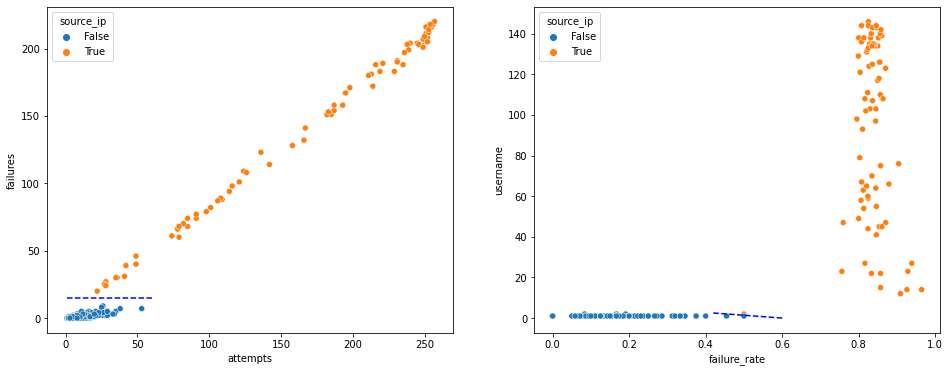

In [12]:
at_dist = december_assigned.source_ip.isin(pd.read_csv('december_2018_attacks.csv').source_ip)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, (x, y) in zip(axes, (('attempts', 'failures'), ('failure_rate', 'username'))) : ax = sns.scatterplot(
                                                                                                        x = december_assigned[x], 
                                                                                                        y = december_assigned[y], 
                                                                                                        hue = at_dist,
                                                                                                        ax = ax
)
axes[0].plot([60, 0], [15, 15], 'b--')
axes[1].plot([0.6, 0.42], [0, 2.5], 'b--')

# project4
Создание критерия, основывающегося на правилах, при использовании процентной разницы от среднего значения, который помечает IP-адрес, если количество неудач и попыток в пять раз превышает их соответствующее среднее значение, или если количество отдельных имен пользователей в пять раз превышает среднее значение. Промежуток - 1 час.

In [13]:
hourly_ip_logs = december_inf.assign(failures=lambda x: np.invert(x.success)).groupby('source_ip').resample('1H').agg(
            {'username': 'nunique', 'success': 'sum', 'failures': 'sum'}).assign(
                                                                                attempts=lambda x: x.success + x.failures,
                                                                                success_rate=lambda x: x.success / x.attempts,
                                                                                failure_rate=lambda x: 1 - x.success_rate
                                                                                ).dropna().reset_index()

In [14]:
hourly_ip_logs

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,2018-12-11 13:00:00,1,3,0,3,1.0,0.0
1,1.138.149.116,2018-12-11 14:00:00,1,4,0,4,1.0,0.0
2,1.138.149.116,2018-12-15 20:00:00,1,2,0,2,1.0,0.0
3,1.138.149.116,2018-12-17 23:00:00,1,2,0,2,1.0,0.0
4,1.138.149.116,2018-12-18 00:00:00,1,1,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...
1444,97.233.182.38,2018-12-06 03:00:00,1,3,0,3,1.0,0.0
1445,97.233.182.38,2018-12-25 23:00:00,1,1,0,1,1.0,0.0
1446,97.233.182.38,2018-12-29 07:00:00,1,1,0,1,1.0,0.0
1447,97.56.241.22,2018-12-12 04:00:00,1,1,0,1,1.0,0.0


In [15]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)
    return hourly_ip_logs.assign(hour=lambda x: x.datetime.dt.hour).groupby('hour').apply(
                    lambda x: x.sample(10, random_state=0, replace=True).pipe(func, *args, **kwargs, numeric_only=True))

In [16]:
averages = get_baselines(hourly_ip_logs, 'mean')
averages.shape

(24, 7)

In [17]:
averages_h = hourly_ip_logs.assign(hour = lambda x: x.datetime.dt.hour).join(averages, on = 'hour', rsuffix = '_median').assign(
             flag_median = lambda x: np.logical_or(np.logical_and(x.failures_median * 5 <= x.failures,
                                                                  x.attempts_median * 5 <= x.attempts
                                                               ), x.username_median * 5 <= x.username)
).query('flag_median').source_ip.drop_duplicates()

# project5
Рассчет показателей для оценки качества выполнения этих правил.

In [18]:
def evaluate(alerted_ips, attack_ips, log_ips):
    tp = alerted_ips.isin(attack_ips).sum()
    tn = np.invert(np.isin(log_ips[~log_ips.isin(alerted_ips)].unique(), attack_ips)).sum()
    fp = np.invert(alerted_ips.isin(attack_ips)).sum()
    fn = np.invert(attack_ips.isin(alerted_ips)).sum()
    return tp, fp, tn, fn

In [19]:
from functools import partial
scores = partial(evaluate, 
                 attack_ips = pd.read_csv('december_2018_attacks.csv').source_ip, 
                 log_ips = december_inf.source_ip.drop_duplicates())

In [20]:
def classification_stats(tp, fp, tn, fn):
    return {
        'FPR': fp / (fp + tn),
        'FDR': fp / (fp + tp),
        'FNR': fn / (fn + tp),
        'FOR': fn / (fn + tn)
}

In [21]:
classification_stats(*scores(averages_h))

{'FPR': 0.0,
 'FDR': 0.0,
 'FNR': 0.19230769230769232,
 'FOR': 0.05514705882352941}